15.12.2021

Load a bunch of UNet predictions in folder `trainings_validation` and compute some metrics, plots, etc.

Predictions are saved as:
`{training_name}_{epoch}_{video_id}_{class}.tif`

**Idea**: Use predictions to produce plots and tables to visualize the results.

In [1]:
%load_ext autoreload
%autoreload 2

In [46]:
import numpy as np
import glob
import os
import imageio

from scipy.ndimage.morphology import binary_dilation, binary_erosion
from sklearn.metrics import jaccard_score, f1_score

import pandas as pd
import matplotlib.pyplot as plt

import unet
from metrics_tools import (correspondences_precision_recall, 
                           Metrics, 
                           reduce_metrics, 
                           empty_marginal_frames,
                           process_spark_prediction,
                           process_puff_prediction,
                           process_wave_prediction,
                           write_videos_on_disk,
                           get_sparks_locations_from_mask,
                           compute_prec_rec,
                           reduce_metrics_thresholds
                          )

In [3]:
BASEDIR = os.path.abspath('')
BASEDIR

'C:\\Users\\dotti\\sparks_project\\sparks'

### Select predictions to load

In [8]:
training_names = ["temporal_reduction",
                  "normalize_whole_video",
                  "reduce_first_layer_channels_64",
                  "256_long_chunks_physio",
                  "256_long_chunks_64_step_physio"
                  ]

epoch = 100000

### Configure input/output folder

In [9]:
metrics_folder = "trainings_validation"

### Load predictions

In [10]:
ys = {} # contains annotations for each training
sparks = {} # contains sparks for each training
puffs = {} # contains puffs for each training
waves = {} # contains waves for each training

for training_name in training_names:
    # Import .tif files as numpy array
    base_name = os.path.join(metrics_folder,training_name+"_"+str(epoch)+"_")
    
    ys_filenames = sorted(glob.glob(base_name+"*_ys.tif"))
    sparks_filenames = sorted(glob.glob(base_name+"*_sparks.tif"))
    puffs_filenames = sorted(glob.glob(base_name+"*_puffs.tif"))
    waves_filenames = sorted(glob.glob(base_name+"*_waves.tif"))
    
    training_ys = []
    training_sparks = []
    training_puffs = []
    training_waves = []
    
    for y,s,p,w in zip(ys_filenames,sparks_filenames,puffs_filenames,waves_filenames):
        training_ys.append(np.asarray(imageio.volread(y)).astype('int'))
        training_sparks.append(np.asarray(imageio.volread(s)))
        training_puffs.append(np.asarray(imageio.volread(p)))
        training_waves.append(np.asarray(imageio.volread(w)))
        
    ys[training_name] = training_ys
    sparks[training_name] = training_sparks
    puffs[training_name] = training_puffs
    waves[training_name] = training_waves        

## Jaccard index for puffs and waves
12.05.2021
Seguendo il consiglio di Pablo:
erosion & dilation delle annotations -> creazione di una exclusion region che viene ignorata dal supporto del Jaccard index

In [7]:
# Define function

def jaccard_score_exclusion_zone(ys,preds,exclusion_radius,sparks=False):
    
    # Compute intersection and union
    intersection = np.logical_and(ys, preds)
    union = np.logical_or(ys, preds)
    
    if exclusion_radius != 0:
        # Compute exclusion zone: 1 where Jaccard index has to be computed, 0 otherwise
        dilated = binary_dilation(ys, iterations=exclusion_radius)
        
        if not sparks:
            eroded = binary_erosion(ys, iterations=exclusion_radius)
            exclusion_mask = 1 - np.logical_xor(eroded,dilated)
        else:
            # Erosion is not computed for spark class
            exclusion_mask = 1 - np.logical_xor(ys,dilated)
    
        # Compute intersecion of exclusion mask with intersection and union
        intersection = np.logical_and(intersection, exclusion_mask)
        union = np.logical_and(union, exclusion_mask)
        
    #print("Pixels in intersection:", np.count_nonzero(intersection))
    #print("Pixels in union:", np.count_nonzero(union))
        
    if np.count_nonzero(union) != 0:
        iou = np.count_nonzero(intersection)/np.count_nonzero(union)
    else:
        iou = 1.
    
    return iou

## Compute metrics for sample video

In [8]:
# results for a sample movie in sample dataset
name = "temporal_reduction"
idx = 0

In [33]:
ignore_frames = 6

### Get binary preds and remove ignored frames

In [32]:
# get predictions
sparks_sample = sparks[name][idx]
puffs_sample = puffs[name][idx]
waves_sample = waves[name][idx]

In [34]:
t_detection = 0.5
min_radius_puffs = 4
min_radius_waves = 10

puffs_binary = process_puff_prediction(puffs_sample, 
                                       t_detection, 
                                       min_radius_puffs, 
                                       ignore_frames)

waves_binary = process_wave_prediction(waves_sample, 
                                       t_detection, 
                                       min_radius_waves, 
                                       ignore_frames)

### Get binary ys and remove ignored frames

In [35]:
# get binary ys
ys_sample = ys[name][idx]

ys_puffs_sample = np.where(ys_sample==3,1,0)
ys_waves_sample = np.where(ys_sample==2,1,0)

In [36]:
ys_puffs_sample = empty_marginal_frames(ys_puffs_sample, ignore_frames)
ys_waves_sample = empty_marginal_frames(ys_waves_sample, ignore_frames)

### Plot a sample frame

In [12]:
sparks_sample.shape, puffs_sample.shape, waves_sample.shape, ys_sample.shape

((125, 64, 512), (125, 64, 512), (125, 64, 512), (125, 64, 512))

In [23]:
sample_frame = 59

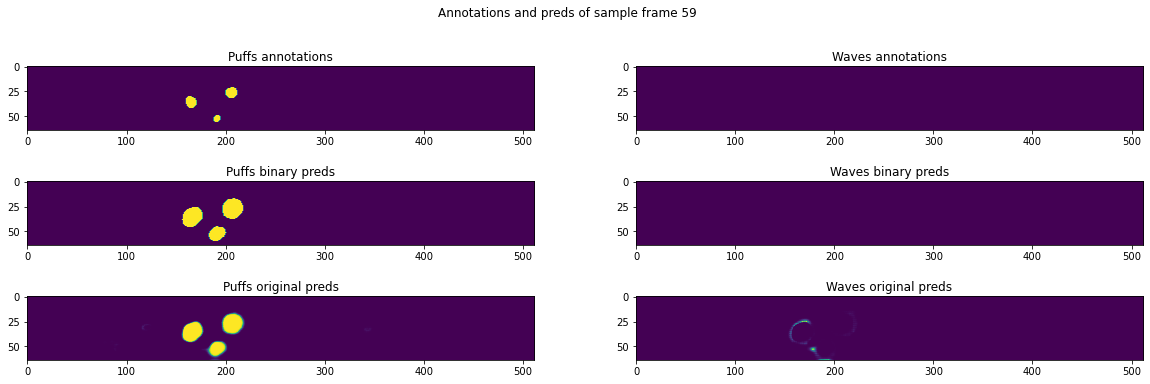

In [28]:
# Plot annotations and preds of sample frame

#plt.rcParams.update({'font.size': 8})

plt.figure(figsize=(20,6))
plt.suptitle(f"Annotations and preds of sample frame {sample_frame}", fontsize=12)


ax = plt.subplot(3,2,1)
ax.set_title("Puffs annotations")
plt.imshow(ys_puffs_sample[sample_frame])

ax = plt.subplot(3,2,2)
ax.set_title("Waves annotations")
plt.imshow(ys_waves_sample[sample_frame])

ax = plt.subplot(3,2,3)
ax.set_title("Puffs binary preds")
plt.imshow(puffs_binary[sample_frame])

ax = plt.subplot(3,2,4)
ax.set_title("Waves binary preds")
plt.imshow(waves_binary[sample_frame])

ax = plt.subplot(3,2,5)
ax.set_title("Puffs original preds")
plt.imshow(puffs_sample[sample_frame])

ax = plt.subplot(3,2,6)
ax.set_title("Waves original preds")
plt.imshow(waves_sample[sample_frame])


plt.show()

### Save sample binary preds on disk

In [29]:
imageio.volwrite(os.path.join(metrics_folder, "binary_preds_puffs.tif"), np.uint8(puffs_binary))
imageio.volwrite(os.path.join(metrics_folder, "binary_preds_waves.tif"), np.uint8(waves_binary))

### Save sample annotations on disk

In [30]:
imageio.volwrite(os.path.join(metrics_folder, "annotations_puffs.tif"), np.uint8(ys_puffs_sample))
imageio.volwrite(os.path.join(metrics_folder, "annotations_waves.tif"), np.uint8(ys_waves_sample))

### Compute Jaccard score (without exclusion zone)

In [60]:
iou_puffs = jaccard_score(ys_puffs_sample.ravel(), puffs_binary.ravel())
iou_waves = jaccard_score(ys_waves_sample.ravel(), waves_binary.ravel())

print(f"Jaccard score puffs: {iou_puffs}")
print(f"Jaccard score waves: {iou_waves}")

Jaccard score puffs: 0.20890103174317864
Jaccard score waves: 0.0


In [43]:
# Compute exclusion zone

exclusion_radius = 2

In [44]:
# Just for puffs
puffs_eroded = binary_erosion(ys_puffs_sample, iterations=exclusion_radius)
puffs_dilated = binary_dilation(ys_puffs_sample, iterations=exclusion_radius)

exclusion_mask = 1 - np.logical_xor(puffs_eroded, puffs_dilated)
# 1 where Jaccard index has to be computed, 0 otherwise

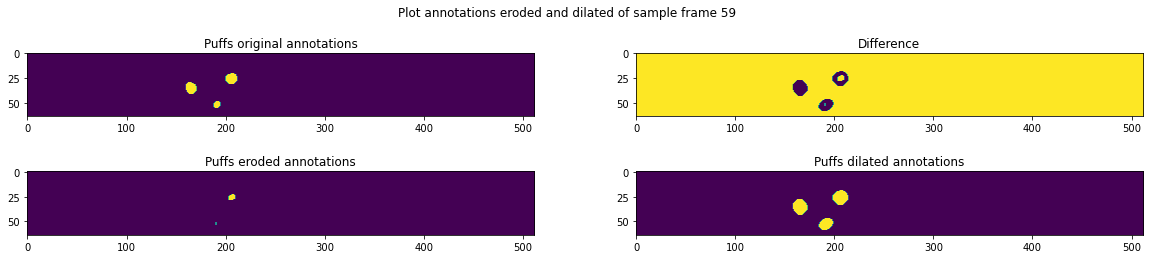

In [47]:
# Plot annotations eroded and dilated
#plt.rcParams.update({'font.size': 8})

plt.figure(figsize=(20,4))
plt.suptitle(f"Plot annotations eroded and dilated of sample frame {sample_frame}", fontsize=12)


ax = plt.subplot(2,2,1)
ax.set_title("Puffs original annotations")
plt.imshow(ys_puffs_sample[sample_frame])

ax = plt.subplot(2,2,2)
ax.set_title("Difference")
plt.imshow(1 - np.logical_xor(puffs_eroded,puffs_dilated)[sample_frame])

ax = plt.subplot(2,2,3)
ax.set_title("Puffs eroded annotations")
plt.imshow(puffs_eroded[sample_frame])

ax = plt.subplot(2,2,4)
ax.set_title("Puffs dilated annotations")
plt.imshow(puffs_dilated[sample_frame])


plt.show()

In [48]:
# Compute intersection and union of annotations with preds

intersection = np.logical_and(ys_puffs_sample, puffs_binary)
union = np.logical_or(ys_puffs_sample, puffs_binary)

# Compute intersection and union only in exclusion mask

intersection_mask = np.logical_and(intersection, exclusion_mask)
union_mask = np.logical_and(union, exclusion_mask)

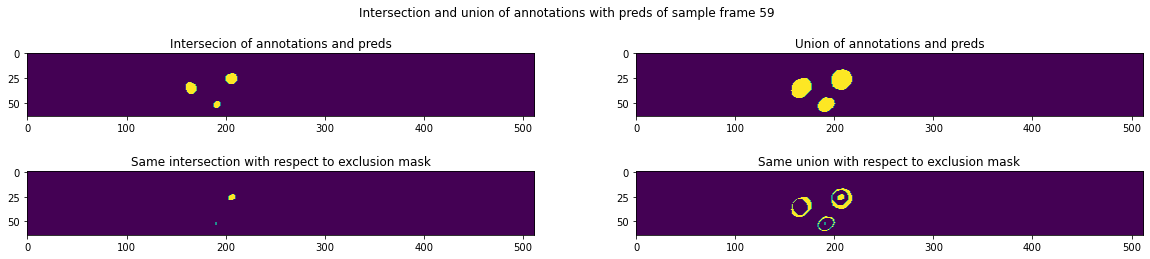

In [49]:
# Plot intersection and union
#plt.rcParams.update({'font.size': 8})

plt.figure(figsize=(20,4))
plt.suptitle(f"Intersection and union of annotations with preds of sample frame {sample_frame}", fontsize=12)


ax = plt.subplot(2,2,1)
ax.set_title("Intersecion of annotations and preds")
plt.imshow(intersection[sample_frame])

ax = plt.subplot(2,2,2)
ax.set_title("Union of annotations and preds")
plt.imshow(union[sample_frame])

ax = plt.subplot(2,2,3)
ax.set_title("Same intersection with respect to exclusion mask")
plt.imshow(intersection_mask[sample_frame])

ax = plt.subplot(2,2,4)
ax.set_title("Same union with respect to exclusion mask")
plt.imshow(union_mask[sample_frame])


plt.show()

In [50]:
# Compute Jaccard index

print(f"Pixels in intersection: {np.count_nonzero(intersection_mask)}")
print(f"Pixels in union: {np.count_nonzero(union_mask)}")

new_iou_puffs = np.count_nonzero(intersection_mask)/np.count_nonzero(union_mask)

print(f"IoU wrt to wave class: {new_iou_puffs}")

Pixels in intersection: 2397
Pixels in union: 29495
IoU wrt to wave class: 0.08126801152737752


In [69]:
new_iou_puffs = jaccard_score_exclusion_zone(ys_puffs_sample, puffs_binary, exclusion_radius)
new_iou_waves = jaccard_score_exclusion_zone(ys_waves_sample, waves_binary, exclusion_radius)

Pixels in intersection: 2397
Pixels in union: 29495
Pixels in intersection: 0
Pixels in union: 0


In [70]:
print(new_iou_puffs)
print(new_iou_waves)

0.08126801152737752
1.0


### Jaccard index for sparks

In [73]:
# get sparks annotations
ys_sparks_sample = np.where(ys_sample==1,1,0)

# get sparks predictions
t_detection_sparks = 0.9
min_radius_sparks = 3
sparks_binary = (process_spark_prediction(sparks_sample, 
                                          t_detection=t_detection_sparks,
                                          min_radius=min_radius_sparks,
                                          ignore_frames=ignore_frames,
                                          return_clean_pred=True)) != 0 

### Comparison with original implementation (when radius = 0)

In [76]:
print("Jaccard index with new method:")
print(f"Puffs: {jaccard_score_exclusion_zone(ys_puffs_sample, puffs_binary, 0)}")
print(f"Waves: {jaccard_score_exclusion_zone(ys_waves_sample, waves_binary, 0)}")
print(f"Sparks: {jaccard_score_exclusion_zone(ys_sparks_sample, sparks_binary, 0, sparks=True)}")
print()
print("Jaccard index with sklearn metrics method")
print(f"Puffs: {jaccard_score(ys_puffs_sample.ravel(), puffs_binary.ravel())}")
print(f"Waves: {jaccard_score(ys_waves_sample.ravel(), waves_binary.ravel())}")
print(f"Sparks: {jaccard_score(ys_sparks_sample.ravel(), sparks_binary.ravel())}")

Jaccard index with new method:
Puffs: 0.20890103174317864
Waves: 1.0
Sparks: 0.04723618090452261

Jaccard index with sklearn metrics method
Puffs: 0.20890103174317864
Waves: 0.0
Sparks: 0.04723618090452261


### Plot IoU with respect to different exclusion radius

In [77]:
exclusion_radius_list = [0,1,2,3,4,5,6,7,8,9,10]

# puffs
ious_puffs = []
for radius in exclusion_radius_list:
    ious_puffs.append(jaccard_score_exclusion_zone(ys_puffs_sample, puffs_binary, radius))
    
# waves
ious_waves = []
for radius in exclusion_radius_list:
    ious_waves.append(jaccard_score_exclusion_zone(ys_waves_sample, waves_binary, radius))
    
# sparks
ious_sparks = []
for radius in exclusion_radius_list:
    ious_sparks.append(jaccard_score_exclusion_zone(ys_sparks_sample, sparks_binary, radius, sparks=True))

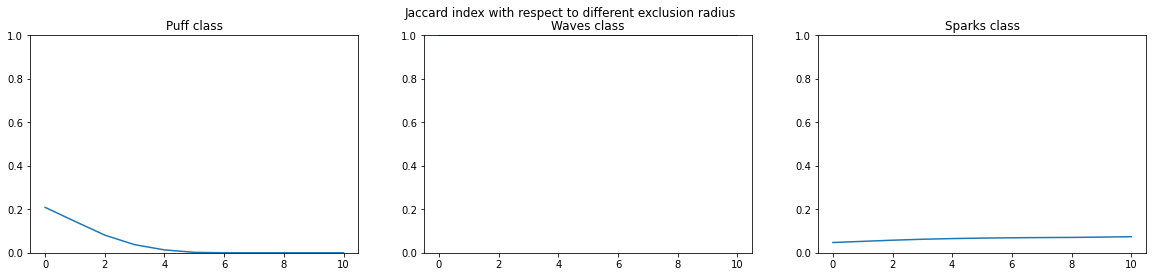

In [78]:
# Plot Jaccard index wrt different exclusion radius
#plt.rcParams.update({'font.size': 8})

plt.figure(figsize=(20,4))
plt.suptitle(f"Jaccard index with respect to different exclusion radius", fontsize=12)


ax = plt.subplot(1,3,1)
ax.set_title("Puff class")
plt.ylim([0, 1])
plt.plot(exclusion_radius_list, ious_puffs)

ax = plt.subplot(1,3,2)
ax.set_title("Waves class")
plt.ylim([0, 1])
plt.plot(exclusion_radius_list, ious_waves)

ax = plt.subplot(1,3,3)
ax.set_title("Sparks class")
plt.ylim([0, 1])
plt.plot(exclusion_radius_list, ious_sparks)


plt.show()

In [79]:
print(f"IoUs puffs: {ious_puffs}")
print(f"IoUs puffs: {ious_waves}")
print(f"IoUs puffs: {ious_sparks}")

IoUs puffs: [0.20890103174317864, 0.14459408432976714, 0.08126801152737752, 0.037353441136730156, 0.013306755737528283, 0.0021321961620469083, 7.474400179385604e-05, 0.0, 0.0, 0.0, 0.0]
IoUs puffs: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
IoUs puffs: [0.04723618090452261, 0.05264336917562724, 0.05791030064070971, 0.06230116648992577, 0.06536856745479833, 0.06762589928057554, 0.06909732431637754, 0.07004470938897168, 0.07078313253012049, 0.07219662058371736, 0.07413249211356467]


## Evaluate all trainings on all videos

In [11]:
# parameters
ignore_frames = 6

t_detection = 0.5
t_detection_sparks = 0.9

min_radius_puffs = 4
min_radius_waves = 10
min_radius_sparks = 3

exclusion_radius_list = [0,1,2,3,4,5,6,7,8,9,10]

# each dictionary contains, for every training name, a list of IoU scores for all videos for all exclusion radius
ious_sparks_all_trainings = {} # num trainings x num video x num exclusion radius
ious_puffs_all_trainings = {}
ious_waves_all_trainings = {}

for training_name in training_names:
    # get predictions
    sparks_training = sparks[training_name]
    puffs_training = puffs[training_name]
    waves_training = waves[training_name]
    
    # get annotations
    ys_training = ys[training_name]
    
    ious_puffs_all_video = []
    ious_waves_all_video = []
    ious_sparks_all_video = []
    
    for sparks_sample, puffs_sample, waves_sample, ys_sample in zip(sparks_training, puffs_training, waves_training, ys_training):
        # get binary predictions and remove ignored frames
        puffs_binary = process_puff_prediction(puffs_sample, 
                                               t_detection, 
                                               min_radius_puffs, 
                                               ignore_frames)
        waves_binary = process_wave_prediction(waves_sample, 
                                               t_detection, 
                                               min_radius_waves, 
                                               ignore_frames)
        sparks_binary = (process_spark_prediction(sparks_sample, 
                                                  t_detection=t_detection_sparks,
                                                  min_radius=min_radius_sparks,
                                                  ignore_frames=ignore_frames,
                                                  return_clean_pred=True)) != 0 
        
        # get binary ys and remove ignored frames
        ys_sparks_sample = empty_marginal_frames(np.where(ys_sample==1,1,0), ignore_frames)
        ys_puffs_sample = empty_marginal_frames(np.where(ys_sample==3,1,0), ignore_frames)
        ys_waves_sample = empty_marginal_frames(np.where(ys_sample==2,1,0), ignore_frames)
        
        
        # compute IoU for some exclusion radius values
        # puffs
        ious_puffs = []
        for radius in exclusion_radius_list:
            ious_puffs.append(jaccard_score_exclusion_zone(ys_puffs_sample, puffs_binary, radius))
            
        ious_puffs_all_video.append(ious_puffs)

        # waves
        ious_waves = []
        for radius in exclusion_radius_list:
            ious_waves.append(jaccard_score_exclusion_zone(ys_waves_sample, waves_binary, radius))
            
        ious_waves_all_video.append(ious_waves)

        # sparks
        ious_sparks = []
        for radius in exclusion_radius_list:
            ious_sparks.append(jaccard_score_exclusion_zone(ys_sparks_sample, sparks_binary, radius, sparks=True))
            
        ious_sparks_all_video.append(ious_sparks)
        
    ious_sparks_all_trainings[training_name] = ious_sparks_all_video
    ious_puffs_all_trainings[training_name] = ious_puffs_all_video
    ious_waves_all_trainings[training_name] = ious_waves_all_video

### Compute average along videos of IoU for each exclusion radius for each training name

In [12]:
ious_sparks_avg = {} # num training x num exclusion radius
ious_puffs_avg = {}
ious_waves_avg = {}

for training_name in training_names:
    num_videos = len(ious_sparks_all_trainings[training_name])
    
    ious_sparks_all_video = ious_sparks_all_trainings[training_name] # num videos x num exclusion radius
    ious_puffs_all_video = ious_puffs_all_trainings[training_name] 
    ious_waves_all_video = ious_waves_all_trainings[training_name] 
    
    ious_sparks_avg[training_name] = np.sum(np.asarray(ious_sparks_all_video),0)/num_videos
    ious_puffs_avg[training_name] = np.sum(np.asarray(ious_puffs_all_video),0)/num_videos
    ious_waves_avg[training_name] = np.sum(np.asarray(ious_waves_all_video),0)/num_videos

### Plot average IoU for all trainings and all classes wrt to exclusion radius

In [13]:
cols = pd.Index(exclusion_radius_list, name='Exclusion radius')
classes = ['Sparks', 'Puffs', 'Waves']
rows = pd.MultiIndex.from_product([classes, training_names], names=['Class', 'Training name'])

data = [*ious_sparks_avg.values(),
        *ious_puffs_avg.values(),
        *ious_waves_avg.values()
       ]

df = pd.DataFrame(data, rows, cols)

In [14]:
display(df)

Exclusion radius                             0         1         2         3   \
Class  Training name                                                            
Sparks temporal_reduction              0.013768  0.014983  0.016290  0.017402   
       normalize_whole_video           0.031568  0.032936  0.034666  0.036527   
       reduce_first_layer_channels_64  0.029137  0.030524  0.032408  0.034686   
       256_long_chunks_physio          0.048356  0.051430  0.055309  0.059401   
       256_long_chunks_64_step_physio  0.050156  0.053397  0.057603  0.062086   
Puffs  temporal_reduction              0.192403  0.195391  0.193384  0.193276   
       normalize_whole_video           0.115751  0.111523  0.106251  0.100328   
       reduce_first_layer_channels_64  0.142396  0.142846  0.140518  0.136384   
       256_long_chunks_physio          0.179951  0.187673  0.193554  0.199717   
       256_long_chunks_64_step_physio  0.192656  0.204125  0.210341  0.213665   
Waves  temporal_reduction              0.789790  0.792825  0.793795  0.793387   
       normalize_whole_video           0.333218  0.332681  0.332053  0.331322   
       reduce_first_layer_channels_64  0.346097  0.346763  0.347260  0.347613   
       256_long_chunks_physio          0.760408  0.760485  0.760356  0.760043   
       256_long_chunks_64_step_physio  0.724859  0.725226  0.725274  0.725052   

Exclusion radius                             4         5         6         7   \
Class  Training name                                                            
Sparks temporal_reduction              0.018239  0.018827  0.019242  0.019531   
       normalize_whole_video           0.038286  0.039816  0.041089  0.042133   
       reduce_first_layer_channels_64  0.037098  0.039382  0.041367  0.042917   
       256_long_chunks_physio          0.063048  0.065982  0.068058  0.069435   
       256_long_chunks_64_step_physio  0.066058  0.069086  0.071159  0.072490   
Puffs  temporal_reduction              0.195698  0.198445  0.201277  0.206332   
       normalize_whole_video           0.093841  0.086939  0.079996  0.073299   
       reduce_first_layer_channels_64  0.130460  0.123086  0.114860  0.105952   
       256_long_chunks_physio          0.205327  0.209653  0.212181  0.212361   
       256_long_chunks_64_step_physio  0.214708  0.215273  0.215547  0.214996   
Waves  temporal_reduction              0.791436  0.787650  0.782408  0.776009   
       normalize_whole_video           0.330495  0.329595  0.328629  0.327588   
       reduce_first_layer_channels_64  0.347826  0.347932  0.347946  0.347905   
       256_long_chunks_physio          0.759509  0.758743  0.757795  0.756679   
       256_long_chunks_64_step_physio  0.724616  0.723892  0.722873  0.721618   

Exclusion radius                             8         9         10  
Class  Training name                                                 
Sparks temporal_reduction              0.019812  0.020216  0.020705  
       normalize_whole_video           0.042948  0.043593  0.044167  
       reduce_first_layer_channels_64  0.044057  0.044860  0.045416  
       256_long_chunks_physio          0.070255  0.070739  0.071063  
       256_long_chunks_64_step_physio  0.073365  0.073904  0.074222  
Puffs  temporal_reduction              0.212682  0.216564  0.215898  
       normalize_whole_video           0.066526  0.059440  0.051912  
       reduce_first_layer_channels_64  0.096588  0.086594  0.075689  
       256_long_chunks_physio          0.210272  0.206999  0.203451  
       256_long_chunks_64_step_physio  0.213770  0.212277  0.210410  
Waves  temporal_reduction              0.769440  0.764413  0.761052  
       normalize_whole_video           0.326449  0.325202  0.323825  
       reduce_first_layer_channels_64  0.347784  0.347565  0.347174  
       256_long_chunks_physio          0.755320  0.753696  0.751809  
       256_long_chunks_64_step_physio  0.720155  0.718546  0.716747

Text(0.5, 0, 'Exclusion radius')

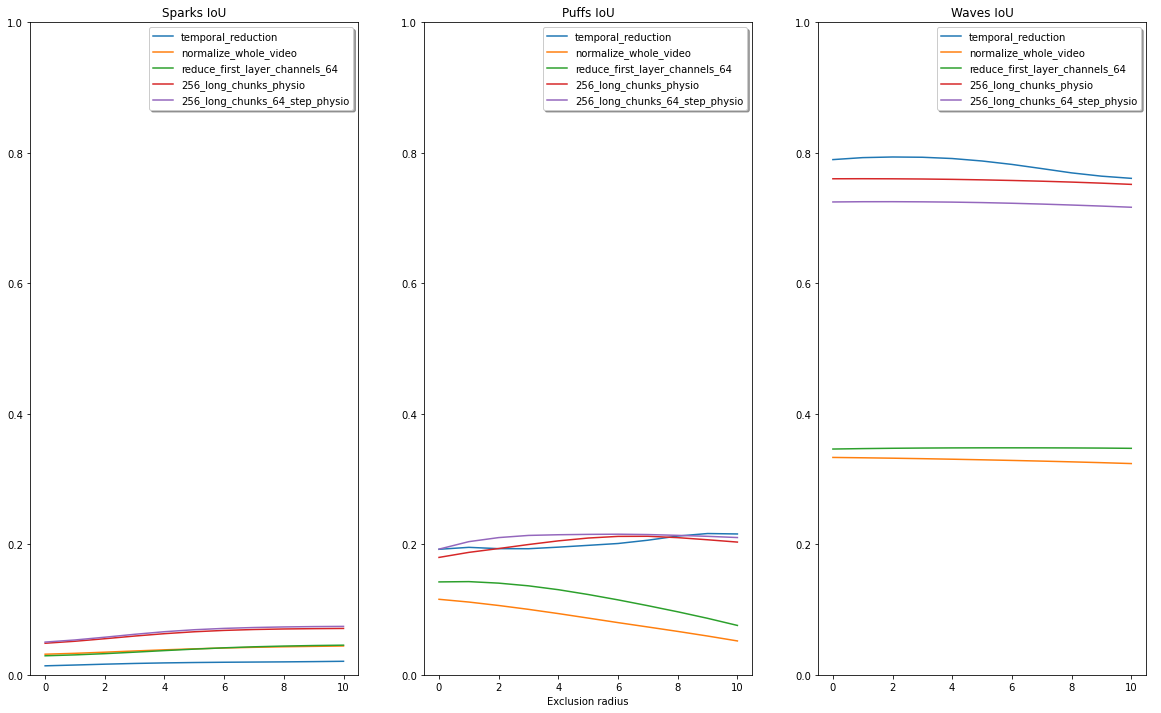

In [15]:
fig, axs = plt.subplots(1, 3, sharex=True, figsize=(20,12))
fig.add_subplot(111, frameon=False)

for training_name in training_names:
    axs[0].plot(exclusion_radius_list, ious_sparks_avg[training_name], label=training_name)
           
axs[0].set_title('Sparks IoU')
axs[0].set_ylim([0,1])
axs[0].legend(shadow=True, fancybox=True)

for training_name in training_names:
    axs[1].plot(exclusion_radius_list, ious_puffs_avg[training_name], label=training_name)

axs[1].set_title('Puffs IoU')
axs[1].set_ylim([0,1])
axs[1].legend(shadow=True, fancybox=True)

for training_name in training_names:
    axs[2].plot(exclusion_radius_list, ious_waves_avg[training_name], label=training_name)

axs[2].set_title('Waves IoU')
axs[2].set_ylim([0,1])
axs[2].legend(shadow=True, fancybox=True)

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Exclusion radius")

## Plot average IoU for different minimal event radius (just for one training)

In [9]:
# set sample training
training_name = training_names[0]

# parameters
ignore_frames = 6

t_detection = 0.5
t_detection_sparks = 0.9

min_radius = [0,1,2,3,4]#,5,6,7,8,9,10]

exclusion_radius_list = [0,1,2,3,4,5,6,7,8,9,10]

# each dictionary contains, for every minimal event radius, a list of IoU scores averaged on all videos for all exclusion radius
ious_sparks_all_radius = {} # num min event radius x num ious_sparks_avg_radiususion radius
ious_puffs_all_radius = {}
ious_waves_all_radius = {}

for r in min_radius:
    # get predictions
    sparks_training = sparks[training_name]
    puffs_training = puffs[training_name]
    waves_training = waves[training_name]
    
    # get annotations
    ys_training = ys[training_name]
    
    ious_puffs_all_video = []
    ious_waves_all_video = []
    ious_sparks_all_video = []
    
    for sparks_sample, puffs_sample, waves_sample, ys_sample in zip(sparks_training, puffs_training, waves_training, ys_training):
        # get binary predictions and remove ignored frames
        puffs_binary = process_puff_prediction(puffs_sample, 
                                               t_detection, 
                                               r, 
                                               ignore_frames)
        waves_binary = process_wave_prediction(waves_sample, 
                                               t_detection, 
                                               r, 
                                               ignore_frames)
        sparks_binary = (process_spark_prediction(sparks_sample, 
                                                  t_detection=t_detection_sparks,
                                                  min_radius=r,
                                                  ignore_frames=ignore_frames,
                                                  return_clean_pred=True)) != 0 
        
        # get binary ys and remove ignored frames
        ys_sparks_sample = empty_marginal_frames(np.where(ys_sample==1,1,0), ignore_frames)
        ys_puffs_sample = empty_marginal_frames(np.where(ys_sample==3,1,0), ignore_frames)
        ys_waves_sample = empty_marginal_frames(np.where(ys_sample==2,1,0), ignore_frames)
        
        
        # compute IoU for some exclusion radius values
        # puffs
        ious_puffs = []
        for radius in exclusion_radius_list:
            ious_puffs.append(jaccard_score_exclusion_zone(ys_puffs_sample, puffs_binary, radius))
            
        ious_puffs_all_video.append(ious_puffs)

        # waves
        ious_waves = []
        for radius in exclusion_radius_list:
            ious_waves.append(jaccard_score_exclusion_zone(ys_waves_sample, waves_binary, radius))
            
        ious_waves_all_video.append(ious_waves)

        # sparks
        ious_sparks = []
        for radius in exclusion_radius_list:
            ious_sparks.append(jaccard_score_exclusion_zone(ys_sparks_sample, sparks_binary, radius, sparks=True))
            
        ious_sparks_all_video.append(ious_sparks)
        
    ious_sparks_all_radius[r] = ious_sparks_all_video
    ious_puffs_all_radius[r] = ious_puffs_all_video
    ious_waves_all_radius[r] = ious_waves_all_video

### Compute average along videos of IoU for each exclusion radius for each minimal event radius

In [10]:
ious_sparks_avg_radius = {} # num min event radius x num exclusion radius
ious_puffs_avg_radius = {}
ious_waves_avg_radius = {}

for r in min_radius:
    num_videos = len(ious_sparks_all_radius[r])
    
    ious_sparks_all_video = ious_sparks_all_radius[r] # num videos x num exclusion radius
    ious_puffs_all_video = ious_puffs_all_radius[r] 
    ious_waves_all_video = ious_waves_all_radius[r] 
    
    ious_sparks_avg_radius[r] = np.sum(np.asarray(ious_sparks_all_video),0)/num_videos
    ious_puffs_avg_radius[r] = np.sum(np.asarray(ious_puffs_all_video),0)/num_videos
    ious_waves_avg_radius[r] = np.sum(np.asarray(ious_waves_all_video),0)/num_videos

### Plot average IoU for all minimal event radius and all classes wrt to exclusion radius

In [11]:
cols = pd.Index(exclusion_radius_list, name='Exclusion radius')
classes = ['Sparks', 'Puffs', 'Waves']
rows = pd.MultiIndex.from_product([classes, min_radius], names=['Class', 'Minimal event radius'])

data = [*ious_sparks_avg_radius.values(),
        *ious_puffs_avg_radius.values(),
        *ious_waves_avg_radius.values()
       ]

df = pd.DataFrame(data, rows, cols)

In [12]:
display(df)

,Exclusion radius,0,1,2,3,4,5,6,7,8,9,10
Class,Minimal event radius,,,,,,,,,,,
Sparks,0,0.078100,0.095190,0.105503,0.111145,0.114678,0.116567,0.117518,0.117985,0.118583,0.119080,0.119624
Puffs,0,0.192554,0.195037,0.193005,0.192940,0.195281,0.197851,0.200326,0.205071,0.211045,0.214472,0.213222
Waves,0,0.791240,0.794321,0.795324,0.794920,0.792891,0.788923,0.783481,0.776851,0.769958,0.764430,0.760443


Text(0.5, 0, 'Exclusion radius')

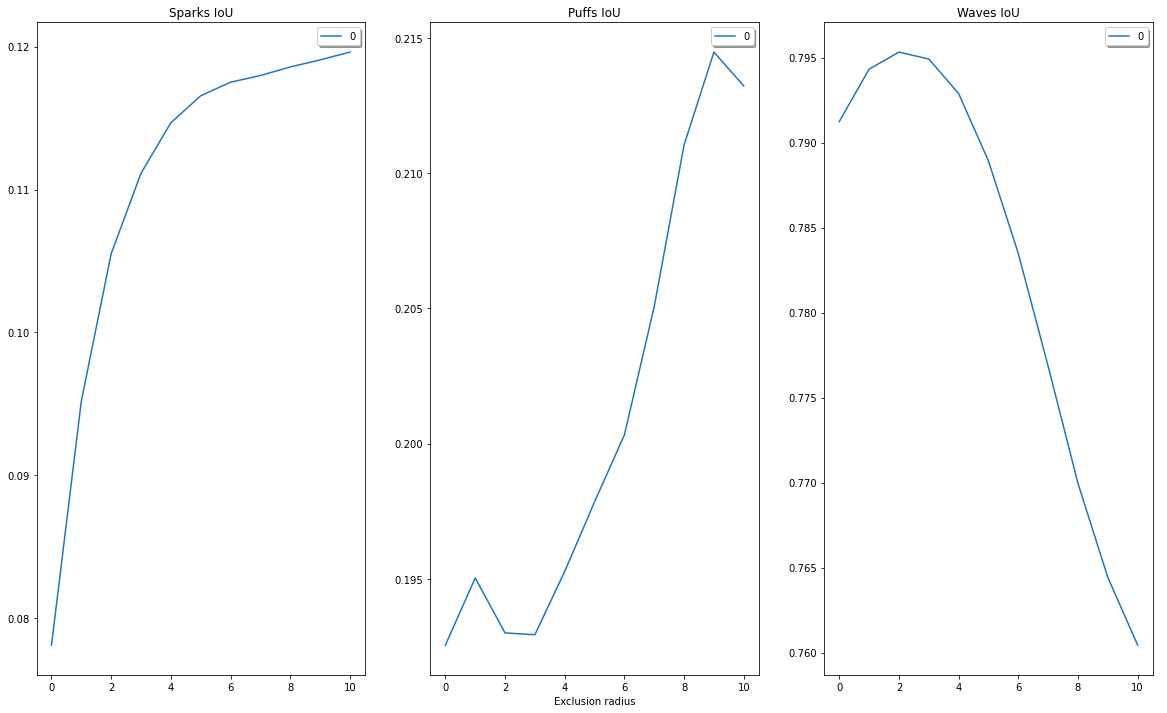

In [15]:
fig, axs = plt.subplots(1, 3, sharex=True, figsize=(20,12))
fig.add_subplot(111, frameon=False)

for r in min_radius:
    axs[0].plot(exclusion_radius_list, ious_sparks_avg_radius[r], label=r)
           
axs[0].set_title('Sparks IoU')
#axs[0].set_ylim([0,1])
axs[0].legend(shadow=True, fancybox=True)

for r in min_radius:
    axs[1].plot(exclusion_radius_list, ious_puffs_avg_radius[r], label=r)

axs[1].set_title('Puffs IoU')
#axs[1].set_ylim([0,1])
axs[1].legend(shadow=True, fancybox=True)

for r in min_radius:
    axs[2].plot(exclusion_radius_list, ious_waves_avg_radius[r], label=r)

axs[2].set_title('Waves IoU')
#axs[2].set_ylim([0,1])
axs[2].legend(shadow=True, fancybox=True)

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Exclusion radius")

## Sparks metrics (TODO)

In [ ]:
def compute_prec_rec(annotations, preds, thresholds, ignore_frames=0,
                     min_radius=3, match_distance=6):
    # annotations: video of sparks segmentation w/ values in {0,1}
    # preds: video of sparks preds w/ values in [0,1]
    # thresholds : list of thresholds applied to the preds over which events are kept
    # min_radius : minimal "radius" of a valid event
    # match_distance : maximal distance between annotation and pred
    # returns a list of Metrics tuples corresponding to thresholds and AUC

    if ignore_frames != 0:
        annotations = empty_marginal_frames(annotations, ignore_frames)
        preds = empty_marginal_frames(preds, ignore_frames)

    metrics = {} # list of 'Metrics' tuples: precision, recall, tp, tp_fp, tp_fn
                 # indexed by threshold value

    coords_true = nonmaxima_suppression(annotations)

    # compute prec and rec for every threshold
    for t in thresholds:
        coords_preds = process_spark_prediction(preds,
                                                t_detection=t,
                                                min_radius=min_radius)

        prec_rec = Metrics(*correspondences_precision_recall(coords_true,
                                                             coords_preds,
                                                             match_distance))

        metrics[t] = prec_rec
        #print("threshold", t)
        #prec.append(prec_rec.precision)
        #rec.append(prec_rec.recall)


    # compute AUC for this sample
    #area_under_curve = auc(rec, prec)

    return metrics#, area_under_curve

def reduce_metrics_thresholds(results):
    # apply metrics reduction to results corresponding to different thresholds
    # results is a list of dicts
    # thresholds is the list of used thresholds
    # returns dicts of reduced 'Metrics' instances for every threshold

    # list of dicts to dict of lists
    results_t = {k: [dic[k] for dic in results] for k in results[0]}

    reduced_metrics = {}
    prec = {}
    rec = {}

    for t, res in results_t.items():
        # res is a list of 'Metrics' of all videos wrt a threshold
        reduced_res = reduce_metrics(res)

        reduced_metrics[t] = reduced_res
        prec[t] = reduced_res.precision
        rec[t] = reduced_res.recall

    # compute area under the curve for reduced metrics
    #print("REC",rec)
    #print("PREC",prec)
    #area_under_curve = roc_auc_score(rec, prec)
    #print("AREA UNDER CURVE", area_under_curve)

    return reduced_metrics, prec, rec, None

In [90]:
# parameters
ignore_frames = 0

t_detection_sparks = [0.7,0.8,0.9,0.95,0.99,0.999]

min_radius_sparks = 3
match_distance = 6

# each dictionary contains, for every training name, a list of prec rec scores for all videos for all thresholds
prec_rec_sparks_all_trainings = {} # num trainings x num video x num thresholds

for training_name in training_names:
    # get predictions
    sparks_training = sparks[training_name]
    
    # get annotations
    ys_training = ys[training_name]
    
    prec_rec_sparks_all_video = []
    
    for sparks_sample, ys_sample in zip(sparks_training, ys_training):
        # get binary ys 
        ys_sparks_sample = np.where(ys_sample==1,1.0,0.0)
        
        # compute precision and recall for some thresholds and remove ignored frames
        prec_rec_all_t = compute_prec_rec(ys_sparks_sample, sparks_sample, 
                                          t_detection_sparks, ignore_frames,
                                          min_radius_sparks, match_distance
                                         ) # dict indexed by threshold value
        prec_rec_sparks_all_video.append(prec_rec_all_t)
        
    prec_rec_sparks_all_trainings[training_name] = prec_rec_sparks_all_video

### Average over all videos

In [92]:
prec_rec_sparks_avg = {} # num training x num thresholds
prec_avg = {}
rec_avg = {}

for training_name in training_names:
    prec_rec_all_videos = prec_rec_sparks_all_trainings[training_name]
    prec_rec_sparks_avg[training_name] = reduce_metrics_thresholds(prec_rec_all_videos)
    prec_avg[training_name] = prec_rec_sparks_avg[training_name][1]
    rec_avg[training_name] = prec_rec_sparks_avg[training_name][2]

### Dataframe and plots of results

In [93]:
cols = pd.Index(t_detection_sparks, name='Detection threshold')
metrics = ['Precision', 'Recall']
rows = pd.MultiIndex.from_product([metrics, training_names], names=['Class', 'Training name'])

data = [*prec_avg.values(),
        *rec_avg.values()
       ]

df = pd.DataFrame(data, rows, cols)

In [94]:
display(df)

Detection threshold                          0.700     0.800     0.900  \
Class     Training name                                                  
Precision temporal_reduction              0.419355  0.488889  0.400000   
          normalize_whole_video           0.190769  0.204301  0.226244   
          reduce_first_layer_channels_64  0.141232  0.155022  0.173684   
          256_long_chunks_physio          0.236256  0.248788  0.272727   
          256_long_chunks_64_step_physio  0.277966  0.289091  0.308642   
Recall    temporal_reduction              0.108333  0.091667  0.050000   
          normalize_whole_video           0.486275  0.447059  0.392157   
          reduce_first_layer_channels_64  0.584314  0.556863  0.517647   
          256_long_chunks_physio          0.623529  0.603922  0.564706   
          256_long_chunks_64_step_physio  0.643137  0.623529  0.588235   

Detection threshold                          0.950     0.990     0.999  
Class     Training name                                                 
Precision temporal_reduction              0.347826  0.000000  1.000000  
          normalize_whole_video           0.234286  0.318750  0.263158  
          reduce_first_layer_channels_64  0.191626  0.273775  0.430556  
          256_long_chunks_physio          0.297872  0.383399  0.650000  
          256_long_chunks_64_step_physio  0.344186  0.440000  0.572816  
Recall    temporal_reduction              0.033333  0.000000  0.000000  
          normalize_whole_video           0.321569  0.200000  0.019608  
          reduce_first_layer_channels_64  0.466667  0.372549  0.121569  
          256_long_chunks_physio          0.494118  0.380392  0.101961  
          256_long_chunks_64_step_physio  0.580392  0.474510  0.231373

In [95]:
prec_avg[training_names[0]].values()

dict_values([0.41935483870967744, 0.4888888888888889, 0.4, 0.34782608695652173, 0.0, 1.0])

Text(0.5, 0, 'Detection threshold')

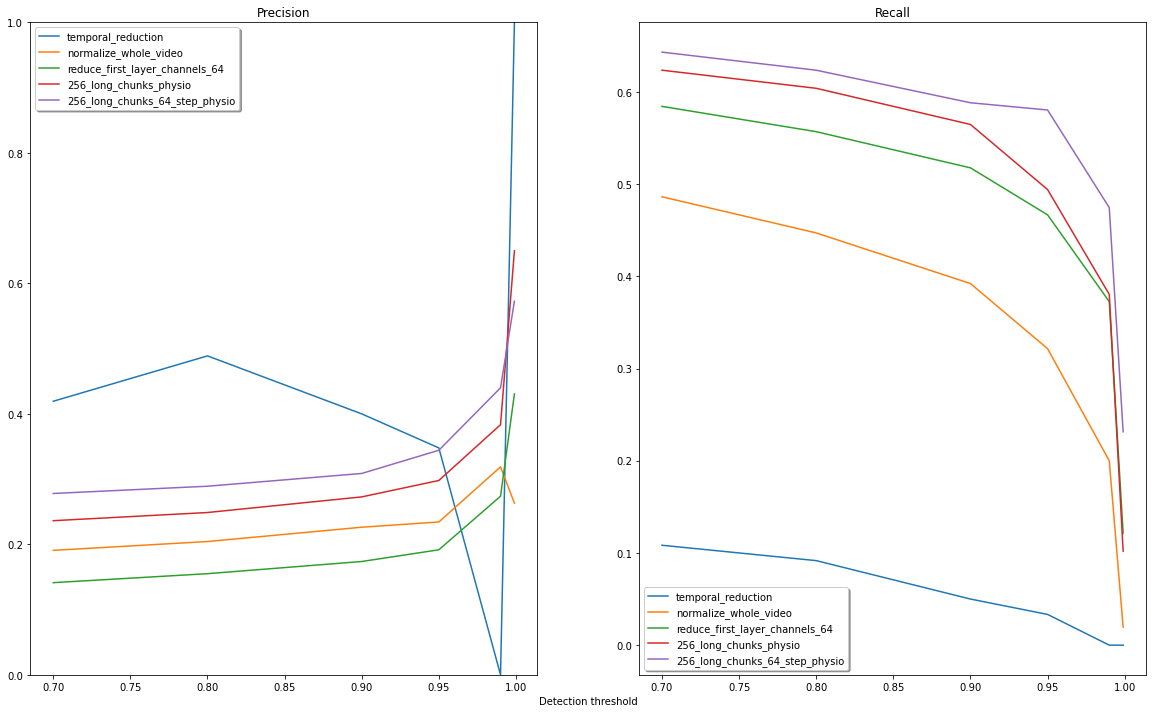

In [96]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(20,12))
fig.add_subplot(111, frameon=False)

for training_name in training_names:
    axs[0].plot(t_detection_sparks, prec_avg[training_name].values(), label=training_name)
           
axs[0].set_title('Precision')
axs[0].set_ylim([0,1])
axs[0].legend(shadow=True, fancybox=True)

for training_name in training_names:
    axs[1].plot(t_detection_sparks, rec_avg[training_name].values(), label=training_name)

axs[1].set_title('Recall')
#axs[1].set_ylim([0,1])
axs[1].legend(shadow=True, fancybox=True)

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Detection threshold")